### Pytorch Tutorial - Autograd & MLP(Multi-layer perceptron)

### Autograd
* autograd 패키지는 텐서의 모든 연산에 대한 자동 미분 제공
* 실행-기반-정의(define-by-run) 프레임워크로, 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 것을 의미
* 역전파는 학습 과정의 매 단계마다 달라짐

### Tensor
* torch.Tensor 클래스의 .requires_grad속성을 True로 설정하면 해당 텐서에서 이루어진 모든 연산 추적(track)하기 시작

* 계산이 완료된 후 .backward()를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 Tensor의 변화도(gradient)는 .grad 속성에 누적됨

* Tensor가 기록을 추적하는 것을 중단하게 하려면 .detach()를 호출하여 연산기록으로부터 분리하여 연산이 추적되는 것을 방지할 수 있음

* 기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해서 코드 블랙을 with.torch.no_grad() : 로 코드를 감쌀 수 있음

* 이는 변화도(gradient)는 필요없지만 requires_grad=True가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용

* Autograd 구현에서 Function 클래스는 매우 중요한 역할을 수행

* Tensor와 Function은 서로 연결되어 있고 모든 연산과정을 부호화하여 순환하지 않는 그래프 생성

* 각 Tensor는 .grad_fn속성을 가지고 있는데 이는 Tensor를 생성한 Function을 참조함(단, 사용자가 만든 Tensor는 예외이며, 사용자가 만든 Tensor가 아닌 연산에 의해 생긴 텐서와 같은 경우는 모두 Function을 참조)
* 도함수를 계산하기 위해서는 Tensor의 .backward()를 호출하면 됨

In [1]:
import torch

print(torch.__version__)

1.12.1+cu113


In [2]:
# x의 연산 과적을 추적하기 위해 requires_grad=True로 설정
x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생선한 Tensor이기 때문에 grad_fn이 None인 것을 확인할 수 있음
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
y = x + 2
y.retain_grad()
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
# 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
print(y.grad_fn)

In [5]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있음
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


* requires_grad_() 를 사용하면 기존 Tensor의 requires_grad 값을 바꿀 수 있음
* 입력 값이 지정되지 않으면 기본 값은 False

In [6]:
a = torch.randn(2, 2)
print(a)

tensor([[-0.8180,  1.3340],
        [-0.0598, -1.6139]])


In [7]:
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad)

tensor([[ 1.3498, 11.9813],
        [ 0.1694,  1.8523]])
False


In [8]:
a.requires_grad_(True)

tensor([[ 1.3498, 11.9813],
        [ 0.1694,  1.8523]], requires_grad=True)

In [9]:
print(a.requires_grad)

True


In [10]:
b = (a * a).sum()
print(b)
print(b.requires_grad)

tensor(148.8320, grad_fn=<SumBackward0>)
True


### 변화도(Gradient)

In [11]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행

y.retain_grad()     # 중간 값에 대한 미분값을 보고싶다면 해당 값에 대한 retain_grad()호출해야함
z.retain_grad()
out.backward()      #여러 번 미분을 진행하기 위해서는 retain_graph=True로 설정해줘야함(그렇지 않으면 아래처럼 에러 발생)

# out.backward(torch.tensor(1.))을 진행하는 것과 동일
print(x.grad)
print(y.grad)
print(z.grad)
print(x.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
True


RuntimeError: ignored

In [12]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

print(out)

y.retain_grad()
out.backward(retain_graph=True)

print(x.grad)
print(y.grad)
print(z.grad)     # z.retain_grad()를 호출하지 않으면 grad값을 저장하지 않기 때문에 grad 속성을 볼 수 없음
print(x.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
True
tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


In [13]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행
# 여러번 역전파를 하기위해서는 retain_graph=True로 지정
out.backward(retain_graph=True)
# out.backward(torch.tensor(1.))을 진행하는 것과 동일

tensor(27., grad_fn=<MeanBackward0>)


RuntimeError: ignored

In [14]:
# 역전파를 진행한 후의 x값
# d(out) / dx
print(x.grad)
print(y.grad)
print(z.is_leaf)

tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])
False


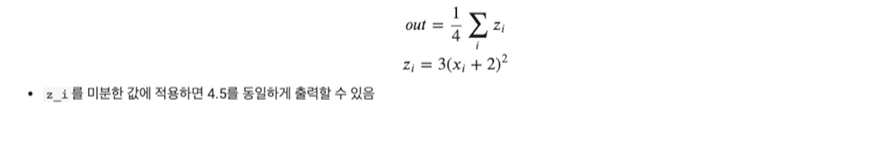

out(미분결과) = 1/4 * 6 * (x + 2) = 3/2(x + 2)

* 일반적으로 `torch.autograd` 는 벡터-야코비안 곱을 계산하는 엔진
* `torch.autograd` 를 사용하면 전체 야코비안을 직접 계산할수는 없지만, 벡터-야코비안 곱은 `backward` 에 해당 벡터를 인자로 제공하여 얻을 수 있음

In [15]:
x = torch.randn(3, requires_grad=True)

y = x * 2

while y.data.norm() < 1000:
  y = y * 2

print(y) 

tensor([  402.4676, -1013.2015,   603.4984], grad_fn=<MulBackward0>)


In [16]:
# scalar값이 아닌 y의 벡터-야코비안 곱을 구하는 과정
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


* `with torch.no_grad()`로 코드 블록을 감싸서 `autograd`가 `.requires_grad=True`인 Tensor의 연산 기록을 추적하는 것을 멈출 수도 있음

In [17]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
  print((x ** 2).requires_grad)

True
True
False


* 또는 .detach()를 호출하여 내용물은 같지만 requires_grad가 다른 새로운 텐서를 가져올 수 있음

In [18]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


### ANN(Artificial Neural Networks)
* 신경망은 `torch.nn`패키지를 사용하여 생성할 수 있음
* `nn`은 모델을 정의하고 미분하기 위해서 살펴본 `autograd`를 사용
* `nn.Module`은 계층(layer)와 `output`을 반환하는 forward(input) 메소드를 포함

* 간단한 순전파 네트워크(feed-forward-network)
* 입력을 받아 여러 계층(layer)에 차례로 전달 후 최종 출력 제공
* 신경망의 일반적인 학습 과정

 * 학습 가능한 매개변수(가중치)를 갖는 신경망 정의
 * 데이터 셋 입력 반복
 * 입력을 신경망에서 전파(process)
 * 손실(loss, 입력값-예측값)를 계산
 * 변화도(gradient)를 신경망의 매개변수들에 의해 역으로 전파 - 역전파 과정
 * 신경망의 가중치 갱신
   * 새로운 가중치(weight) = 가중치(weight)-  학습률(learning rate) * 변화도(gradient)

In [19]:
import pandas as pd

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [20]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x

### 손실함수(Loss function)
* 손실 함수는 (output, target)을 한 쌍으로 입력 받아, 출력이 정답으로부터 얼마나 떨어져있는지 추정하는 값을 계산
* `forward`함수만 정의하고 나면 `backward`함수는 `autograd`를 사용하여 자동으로 정의됨
* 모델의 학습 가능한 매개변수는 `net.parameters()`에 의해 변환됨

In [21]:
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss()

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0])

net = Net()
output = net(ex_X)
loss = criterion(output, ex_y)
print('loss: ', loss.item())
  
net.zero_grad()

print('layer0.bias.grad before backward')
print(net.layer4.bias.grad)

print(net.layer4.bias.is_leaf)

loss.backward()

print('layer0.bias.grad after backward')
print(net.layer4.bias.grad)

"""
이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 논드이기 때문이라고 합니다.
설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)

어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20
왜 leaf 노드만 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7
"""

loss:  1.1628823280334473
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.1821,  0.0589,  0.1232])


'\n이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 논드이기 때문이라고 합니다.\n설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)\n\n어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20\n왜 leaf 노드만 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7\n'

In [22]:
params = list(net.parameters())
print(len(params))
print(params[0].size())    # layer0의 weight

16
torch.Size([128, 4])


### 가중치 갱신
* 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)

* 새로운 가중치(weignt) = 가중치(weignt) - 학습률(learning rate) * 변화도(gradient)

In [23]:
# torch.optim 패키지에 다양한 갱신 규칙이 규현되어 있음

import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001)

optimizer.zero_grad()
output = net(ex_X)
loss = criterion(output, ex_y)
loss.backward()
optimizer.step()  # 업데이트 진행

### MLP 모델

In [24]:
dataset = load_iris()

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [25]:
print('shape of data: ', data.shape)
print('shape of label: ', label.shape)

shape of data:  (150, 4)
shape of label:  (150,)


In [26]:
# 훈련과 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)
print(len(X_train))
print(len(X_test))

84
38


In [27]:
# DataLoader 생성
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [28]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
      x = self.act(self.bn0(self.layer0(x)))
      x = self.act(self.bn1(self.layer1(x)))
      x = self.act(self.bn2(self.layer2(x)))
      x = self.act(self.layer3(x))
      x = self.layer4(x)

      return x
      # return nn.Softmax(x)

In [29]:
net = Net()
print(net)

Net(
  (layer0): Linear(in_features=4, out_features=128, bias=True)
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [30]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 200

In [31]:
losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0  
  epoch_accuracy = 0
  for X, y in train_loader:
  
    optimizer.zero_grad()
    
    output = net(X)

    loss = criterion(output, y)
    loss.backward()
    
    optimizer.step()
    # output = [0.11, 0.5, 0.8]  --> 예측 클래스 값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))
  
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.1359, 	accuracy :0.3214
epoch :002, 	loss :1.1168, 	accuracy :0.3452
epoch :003, 	loss :1.1168, 	accuracy :0.3333
epoch :004, 	loss :1.1097, 	accuracy :0.3214
epoch :005, 	loss :1.0947, 	accuracy :0.381
epoch :006, 	loss :1.063, 	accuracy :0.4286
epoch :007, 	loss :1.0804, 	accuracy :0.4286
epoch :008, 	loss :1.052, 	accuracy :0.5
epoch :009, 	loss :1.053, 	accuracy :0.5119
epoch :010, 	loss :1.0759, 	accuracy :0.369
epoch :011, 	loss :1.0346, 	accuracy :0.5952
epoch :012, 	loss :1.0365, 	accuracy :0.5595
epoch :013, 	loss :1.023, 	accuracy :0.5714
epoch :014, 	loss :1.0008, 	accuracy :0.6667
epoch :015, 	loss :1.0156, 	accuracy :0.5595
epoch :016, 	loss :0.9927, 	accuracy :0.5952
epoch :017, 	loss :1.017, 	accuracy :0.5952
epoch :018, 	loss :0.99, 	accuracy :0.6071
epoch :019, 	loss :0.9773, 	accuracy :0.6429
epoch :020, 	loss :0.9777, 	accuracy :0.6548
epoch :021, 	loss :0.969, 	accuracy :0.6786
epoch :022, 	loss :0.9771, 	accuracy :0.7143
epoch :023, 	loss :0.97

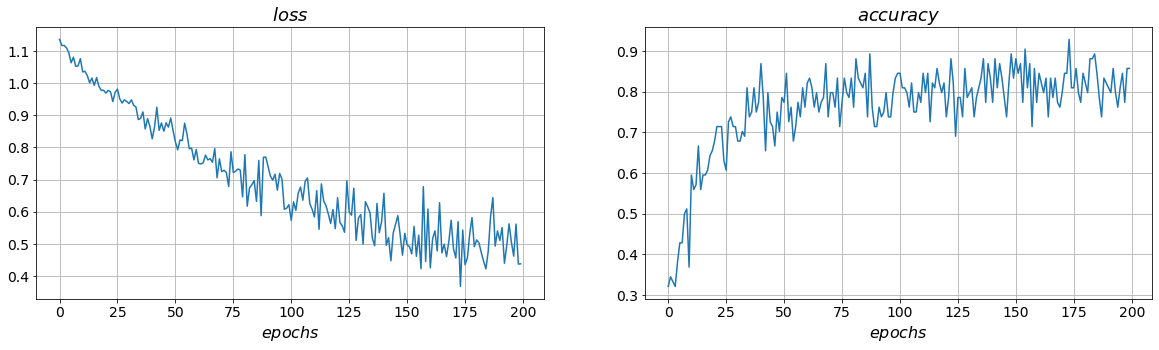

In [32]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [33]:
# Test

output = net(X_test)
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test),4)

print("test_set accuracy :", round(accuracy,4))

torch.return_types.max(
values=tensor([1.9297, 2.0087, 1.2324, 1.0720, 1.7444, 1.2863, 1.4702, 1.3544, 1.5546,
        1.8898, 2.4202, 2.5089, 1.3899, 1.2013, 1.2928, 1.5514, 1.2895, 1.0973,
        1.5640, 1.9095, 2.1366, 1.1320, 1.9270, 1.8740, 2.4173, 0.5918, 2.5252,
        1.6071, 1.4822, 2.6388, 1.0849, 1.5385, 1.2084, 1.1666, 1.6719, 0.9773,
        1.6528, 2.0336], grad_fn=<MaxBackward0>),
indices=tensor([2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1,
        0, 1, 0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 0, 0]))
test_set accuracy : 0.9737
